## Step 0: (Ensure imports + dataset ready)

In [1]:
import pandas as pd  # For loading and handling data in tabular form
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score  # For data splitting and validation
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # For feature scaling and encoding categorical variables
from sklearn.compose import ColumnTransformer  # To apply different preprocessing to different feature types
from sklearn.linear_model import LogisticRegression  # Logistic regression model for binary classification
from sklearn.pipeline import Pipeline  # To build a sequence of preprocessing + model steps
from sklearn.metrics import classification_report, confusion_matrix  # For model evaluation metrics



In [2]:
df = pd.read_csv("with_feature_engineering.csv")  # replace with your file path


In [3]:
df.head()

,year,month,State,type_of_connection,value,date,Service_provider,subscriber_change,churn_flag,type_of_connection_encoded,...,subscribers_lag_6,subscribers_lag_12,subscribers_ma_3,subscribers_ma_6,subscribers_ma_12,yoy_growth,market_share,competitor_count,is_major_operator,is_metro
0,2009,1,ALL INDIA,wireless,16761397.0,01-01-2009,AIRCEL,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.041899,10,0,0
1,2010,1,ALL INDIA,wireless,33035907.0,01-01-2010,AIRCEL,0.970952,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.056909,12,0,0
2,2011,1,ALL INDIA,wireless,51831796.0,01-01-2011,AIRCEL,0.568953,0,0,...,NaN,NaN,3.387637e+07,NaN,NaN,NaN,0.064297,14,0,0
3,2012,1,ALL INDIA,wireless,62462121.0,01-01-2012,AIRCEL,0.205093,0,0,...,NaN,NaN,4.910994e+07,NaN,NaN,NaN,0.066725,14,0,0
4,2013,1,ALL INDIA,wireless,61571291.0,01-01-2013,AIRCEL,-0.014262,0,0,...,NaN,NaN,5.862174e+07,NaN,NaN,NaN,0.068938,12,0,0


## Step 1: Separate features (X) and target (y)

In [4]:
X = df.drop(columns=['churn_flag'])
y = df['churn_flag'].astype(int)


In [5]:
X = X.drop(['subscriber_change', 'yoy_growth'], axis=1, errors='ignore')


In [6]:
X.columns

Index(['year', 'month', 'State', 'type_of_connection', 'value', 'date',
       'Service_provider', 'type_of_connection_encoded',
       'Service_provider_encoded', 'value_scaled', 'subscribers_lag_1',
       'subscribers_lag_3', 'subscribers_lag_6', 'subscribers_lag_12',
       'subscribers_ma_3', 'subscribers_ma_6', 'subscribers_ma_12',
       'market_share', 'competitor_count', 'is_major_operator', 'is_metro'],
      dtype='object')

## Step 2: Handle missing values and drop unusable columns

In [7]:
X = X.drop(columns=['date'], errors='ignore')
X = X.fillna(0)


## Step 3: Define feature types

In [8]:
numeric_features = ['value', 'value_scaled', 'market_share']
categorical_features = ['State', 'Service_provider', 'type_of_connection']


## Step 4: Create preprocessing transformer

In [9]:
# Apply StandardScaler to numeric columns and OneHotEncoder to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),               # Scale numeric data
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Encode categorical data
    ])

## Step 5: Define baseline model pipeline

In [10]:
# Combine preprocessing + logistic regression into one pipeline
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Data preprocessing step
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))  # Logistic Regression model
])


## Step 6: Time series cross-validation setup

In [11]:
tscv = TimeSeriesSplit(n_splits=3)
# For time-based data, ensures no data leakage (past data predicts future)


## Step 7: Evaluate using cross-validation

In [12]:
# Evaluate model performance using F1 score (good for imbalanced data)

scores = cross_val_score(baseline_model, X, y, cv=tscv, scoring='f1')
print("Mean F1 Score:", scores.mean())


Mean F1 Score: 0.614932576620646


In [13]:
import numpy as np

# Check for infinity
np.isinf(X.select_dtypes(include=[float, int])).sum()


year                          0
month                         0
value                         0
type_of_connection_encoded    0
Service_provider_encoded      0
value_scaled                  0
subscribers_lag_1             0
subscribers_lag_3             0
subscribers_lag_6             0
subscribers_lag_12            0
subscribers_ma_3              0
subscribers_ma_6              0
subscribers_ma_12             0
market_share                  0
competitor_count              0
is_major_operator             0
is_metro                      0
dtype: int64

In [14]:
# Fit the model on training data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  
)
# Predict on test data

baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)


In [15]:
# Print precision, recall, f1-score for both classes

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.92      0.84      8961
           1       0.79      0.53      0.63      5185

    accuracy                           0.78     14146
   macro avg       0.78      0.72      0.74     14146
weighted avg       0.78      0.78      0.76     14146

[[8243  718]
 [2453 2732]]


In [16]:
revenue_per_customer = 100
retention_cost = 10

TP = ((y_test == 1) & (y_pred == 1)).sum()
FP = ((y_test == 0) & (y_pred == 1)).sum()

roi = (TP * revenue_per_customer - FP * retention_cost) / (FP * retention_cost + 1e-6)
print(f"ROI: {roi:.2f}")


ROI: 37.05


In [17]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.92      0.84      8961
           1       0.79      0.53      0.63      5185

    accuracy                           0.78     14146
   macro avg       0.78      0.72      0.74     14146
weighted avg       0.78      0.78      0.76     14146



In [18]:
y_pred = baseline_model.predict(X_test)


In [19]:
# Compare predictions and actual values
comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

print(comparison_df.head(20))


    Actual  Predicted
0        1          0
1        0          1
2        0          0
3        1          1
4        0          0
5        0          0
6        0          0
7        0          0
8        1          0
9        1          0
10       1          1
11       0          0
12       0          0
13       0          0
14       0          0
15       1          0
16       1          0
17       1          1
18       0          0
19       0          0


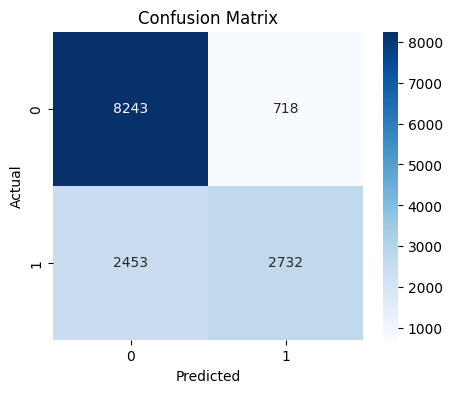

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [21]:
# Example: new unseen record (replace with your real data)
new_data = pd.DataFrame({
    'value': [350],
    'value_scaled': [0.85],
    'market_share': [0.12],
    'State': ['Delhi'],
    'Service_provider': ['Airtel'],
    'type_of_connection': ['Postpaid']
})

# Predict churn (0 = No churn, 1 = Churn)
predicted_churn = baseline_model.predict(new_data)
print("Predicted Churn:", predicted_churn[0])


Predicted Churn: 0


In [23]:
import numpy as np

model = baseline_model.named_steps['classifier']
feature_names = baseline_model.named_steps['preprocessor'].get_feature_names_out()
coefficients = model.coef_[0]

importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print(importance.head(10))


                               Feature  Coefficient
36          cat__Service_provider_BSNL     0.851789
46       cat__Service_provider_TELENOR     0.720638
39           cat__Service_provider_JIO     0.538252
40  cat__Service_provider_LOOP TELECOM     0.527018
11                    cat__State_Delhi     0.476919
22                   cat__State_Mumbai     0.457672
17                cat__State_Karnataka     0.406566
34        cat__Service_provider_AIRTEL     0.403200
18                   cat__State_Kerala     0.391738
12                  cat__State_Gujarat     0.341088


In [26]:
results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})
print(results.head(10))


   Actual  Predicted
0       1          0
1       0          1
2       0          0
3       1          1
4       0          0
5       0          0
6       0          0
7       0          0
8       1          0
9       1          0
